# BERT

Load and install necessary packages:

In [1]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive/')

import pandas as pd
!pip install ktrain
import ktrain
from ktrain import text

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 46.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 68.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.4/265.4 KB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (

Read the preprocessed data in:

In [2]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/yahoo_train.csv')
topic_labels = cleaned_data[['topic', 'topic_name']].drop_duplicates()
cleaned_data = cleaned_data[cleaned_data.topic.isin([0,1,2])].sample(100000).reset_index(drop=True)[['topic', 'text_clean']]

# BERT Model using ktrain

In [3]:
# 2. Create train, validation & preprocessing datasets using texts_from_df in ktrain
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=cleaned_data,
                                                                  text_column='text_clean',
                                                                  label_columns='topic',
                                                                  maxlen=64,
                                                                  val_pct=.3,
                                                                  preprocess_mode='bert')

# 3. Create and Train the BERT Model
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc,
                             multilabel=False) 

# 4. Setting up learner. Batch size is based on previous successes with training BERT on this data.
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=64)

# 5. Fitting model using one-cycle poliy, lr=2e-5 from research paper. 
# One cycle policy comes from paper
learner.fit_onecycle(lr=2e-5, epochs=3);
     
# 6. Get predictor using preproc dataset
predictor = ktrain.get_predictor(learner.model, preproc)   

classes = predictor.get_classes()  
classes


['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
96838      0.0      0.0      1.0
1744       0.0      0.0      1.0
36190      0.0      0.0      1.0
44976      1.0      0.0      0.0
49927      0.0      0.0      1.0
['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
60647      0.0      1.0      0.0
311        0.0      1.0      0.0
63494      0.0      0.0      1.0
69521      0.0      0.0      1.0
64064      0.0      0.0      1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? True
maxlen is 64


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1094/1094 [==============================] - 1103s 985ms/step - loss: 0.2446 - accuracy: 0.8545 - val_loss: 0.2143 - val_accuracy: 0.8752
Epoch 2/3
1094/1094 [==============================] - 1082s 989ms/step - loss: 0.1710 - accuracy: 0.9016 - val_loss: 0.1833 - val_accuracy: 0.8949
Epoch 3/3
1094/1094 [==============================] - 1078s 986ms/step - loss: 0.1170 - accuracy: 0.9364 - val_loss: 0.2011 - val_accuracy: 0.8920


['topic_0', 'topic_1', 'topic_2']

### What does this code do?
- Start with the preprocessed data.
- Texts_from_df- tokenizes and splits the data into X_train, Y_train, etc.
- I specify the text classifier as BERT, and that the preprocessing embedding mode will be BERT as well.
- Specify a learner. I select the batch size as 64 as that is a batch size that has worked well in other papers
- Specify the fitting method as a *1 Cycle Policy*. This approach comes from a paper titled "Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates" Basically the one cycle policy is a training technique that involves gradually increasing the learning rate for a certain number of epochs, then gradually decreasing it for the remaining epochs of training.
  - *Why?* The intuition behind this approach is that a higher learning rate at the beginning of training can help the network to quickly converge towards a good solution, while a lower learning rate towards the end can help it to fine-tune and stabilize that solution.
  - *How does it work?* The one cycle policy involves using a triangular learning rate schedule where the learning rate starts at a lower value, gradually increases to a maximum value, and then gradually decreases back to the initial value over a specified number of epochs. Additionally, the momentum is also varied in a similar triangular fashion.
  - The idea is that this cyclic variation in learning rate and momentum can help to avoid getting stuck in local minima and enable the network to explore more of the parameter space.
- The *get_predictor* returns a Predictor instance that can be used to make predictions on unlabeled examples.

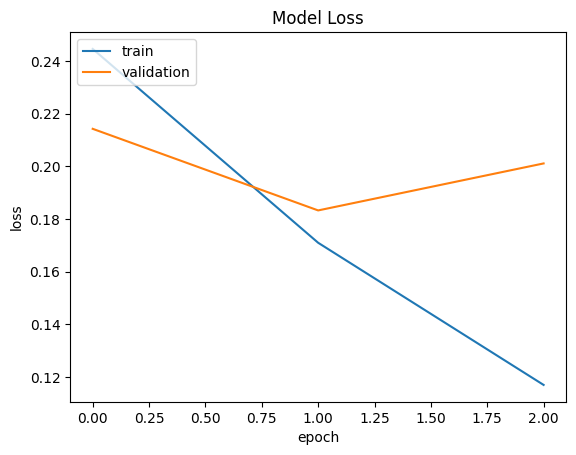

In [5]:
learner.plot('loss')

Now that we've fitted our model, we can predict the test set and assess the performance of our model

In [ ]:
predictions = learner.model.predict(X_test)
class_predictions = np.argmax(predictions, axis=1)
y_class = np.argmax(y_test, axis=1)

array([[4.6023380e-02, 9.5233226e-01, 9.0094805e-03],
       [9.7502202e-01, 9.5482310e-03, 1.1223157e-02],
       [2.4972005e-02, 9.6956015e-01, 2.3645319e-03],
       ...,
       [3.8061517e-01, 3.6410716e-01, 1.5037602e-01],
       [9.9849224e-01, 1.9386645e-03, 9.1922254e-04],
       [2.0222745e-03, 2.8279493e-02, 9.6904880e-01]], dtype=float32)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

precision, recall, fscore, support = score(y_class, class_predictions)

print('Avg precision: {}'.format(precision.mean()))
print('Avg recall: {}'.format(recall.mean()))
print('Avg fscore: {}'.format(fscore.mean()))
print('support: {}'.format(support))

print('Avg accuracy: {}'.format(accuracy_score(y_class, class_predictions)))

Avg precision: 0.8960835003463217
Avg recall: 0.8958970820020138
Avg fscore: 0.8958863355448555
support: [10039 10071  9890]
Avg accuracy: 0.8958666666666667


Heatmap of classification

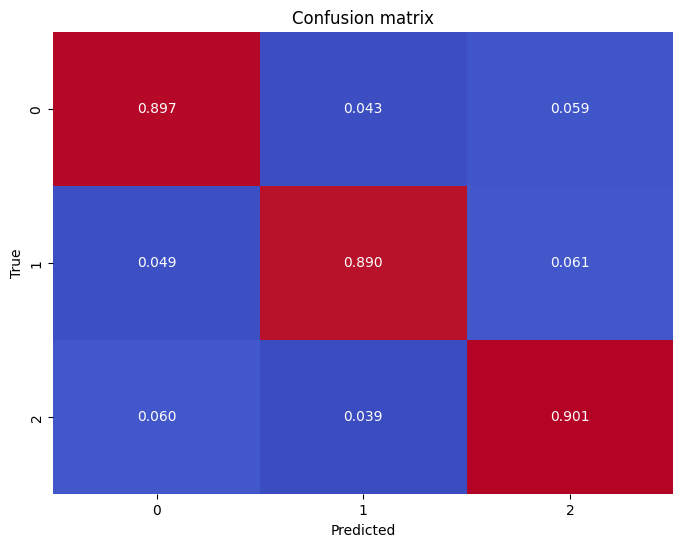

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    cm_proportions = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_proportions, annot=True, cmap='coolwarm', fmt='.3f', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

plot_confusion_matrix(y_class, class_predictions)

# Test prompts
Let's test the model by providing it some test prompts and see what it predicts.

In [ ]:
topics = topic_labels[topic_labels.topic.isin([0,1,2])].sort_values('topic').reset_index(drop=True)


,topic,topic_name
0,0,Society & Culture
1,1,Science & Mathematics
2,2,Health


In [ ]:
a_question = "my head hurts, should I see a doctor?"
another_question = "who do you think will win the best actor at the oscars this year?"
final_question = "If you wish to make an apple pie from scratch, you must first invent the universe"

my head hurts, should I see a doctor?
[('topic_0', 0.01770344), ('topic_1', 0.022975363), ('topic_2', 0.96985406)]
most likely topic: Health
who do you think will win the best actor at the oscars this year?
[('topic_0', 0.9123698), ('topic_1', 0.10343975), ('topic_2', 0.014000283)]
most likely topic: Society & Culture
If you wish to make an apple pie from scratch, you must first invent the universe
[('topic_0', 0.107348755), ('topic_1', 0.8772431), ('topic_2', 0.008619145)]
most likely topic: Science & Mathematics


,topic,topic_name
0,0,Society & Culture
1,1,Science & Mathematics
2,2,Health


In [ ]:
example_predictions = predictor.predict([a_question,another_question,final_question])
# Convert list of tuples to dictionary
dict_output = [{t[0]: t[1] for t in row} for row in example_predictions]

# Create DataFrame from dictionary
output_df = pd.DataFrame(dict_output).set_axis([a_question,another_question,final_question], axis=0).rename(columns={'topic_0': 'Society & Culture', 'topic_1': 'Science & Mathematics', 'topic_2': 'Health'})
output_df['Highest Probability'] = output_df.apply(lambda x: topics.topic_name[np.argmax(x)], axis=1)

In [ ]:
output_df

,Society & Culture,Science & Mathematics,Health,Highest Probability
"my head hurts, should I see a doctor?",0.017703,0.022975,0.969854,Health
who do you think will win the best actor at the oscars this year?,0.912370,0.103440,0.014000,Society & Culture
"If you wish to make an apple pie from scratch, you must first invent the universe",0.107349,0.877243,0.008619,Science & Mathematics


# Error Correction
What happens when we train on 1.5 times the data?

In [ ]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/yahoo_train.csv')
topic_labels = cleaned_data[['topic', 'topic_name']].drop_duplicates()
cleaned_data = cleaned_data[cleaned_data.topic.isin([0,1,2])].sample(150000).reset_index(drop=True)[['topic', 'text_clean']]

In [ ]:
# 2. Create train, validation & preprocessing datasets using texts_from_df in ktrain
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=cleaned_data,
                                                                  text_column='text_clean',
                                                                  label_columns='topic',
                                                                  maxlen=64,
                                                                  val_pct=.3,
                                                                  preprocess_mode='bert')



['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
86116      1.0      0.0      0.0
18895      1.0      0.0      0.0
86987      1.0      0.0      0.0
32684      0.0      0.0      1.0
62508      1.0      0.0      0.0
['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
95580      0.0      0.0      1.0
83830      0.0      1.0      0.0
25775      0.0      0.0      1.0
44326      0.0      1.0      0.0
26568      0.0      0.0      1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [1]:
X_train[:5].shape

NameError: ignored

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

predictions = learner.model.predict(X_test)
class_predictions = np.argmax(predictions, axis=1)
y_class = np.argmax(y_test, axis=1)

precision, recall, fscore, support = score(y_class, class_predictions)

print('Avg precision: {}'.format(precision.mean()))
print('Avg recall: {}'.format(recall.mean()))
print('Avg fscore: {}'.format(fscore.mean()))
print('support: {}'.format(support))

print('Avg accuracy: {}'.format(accuracy_score(y_class, class_predictions)))

1407/1407 [==============================] - 207s 142ms/step
Avg precision: 0.8973257309389565
Avg recall: 0.8970532506373846
Avg fscore: 0.8970965579131582
support: [15084 14986 14930]
Avg accuracy: 0.8970666666666667


In [ ]:
X_train

NameError: ignored